Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Read cloud point from text file

In [2]:
points= np.genfromtxt('2d_pointcloud.txt', delimiter=' ', skip_header=1)
print(points.shape)
print(points[:10])

(721, 4)
[[1.093610e-16 1.786000e+00 0.000000e+00 1.606775e-02]
 [7.757964e-03 1.777983e+00 0.000000e+00 1.599145e-02]
 [1.554196e-02 1.780932e+00 0.000000e+00 1.611353e-02]
 [2.332566e-02 1.781847e+00 0.000000e+00 1.609827e-02]
 [3.130962e-02 1.793727e+00 0.000000e+00 1.651026e-02]
 [4.020483e-02 1.842561e+00 0.000000e+00 1.661707e-02]
 [4.994562e-02 1.907346e+00 0.000000e+00 1.742580e-02]
 [5.906149e-02 1.933098e+00 0.000000e+00 1.736477e-02]
 [6.857751e-02 1.963803e+00 0.000000e+00 1.646448e-02]
 [7.793073e-02 1.983470e+00 0.000000e+00 1.701381e-02]]


In [3]:
# Make it smaller for testing
# points= points[500:]

Trim and visualize data

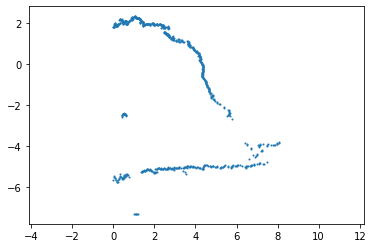

In [4]:
# Remove points with intensity = 0
to_delete= []
for i in range(len(points)):
    if points[i][3] <= 0:
        to_delete.append(i)

# print(to_delete)
        
for i in range(len(to_delete) - 1, -1, -1):
    points= np.delete(points, to_delete[i], axis= 0)

# Plot the point cloud (x, y only)
plt.axes().set_aspect('equal', 'datalim')
plt.plot(points[:, 0:1], points[:, 1:2], 'o', markersize= 1)

Because the cloud point is a 2D image (z is always 0), use a line to represent the ground plane.

Use RANSAC to find the 2 points that form the ground line.

In [5]:
# Threshold distance value to decide if the point is on the plane 
threshold= 0.25
# Threshold value of the percentage of inliers over the whole cloud point to consider if this is the ground plane
inlier_threshold= 0.25

n= len(points)
result= (-1, -1)
candidates= []
D_min= 1000000

In [6]:
# Repeat these steps to find the ground line:
# - In the cloud point, take two points to form a line.
# - Calculate the distance from every point in the cloud point to that line.
# - If that distance is smaller than threshold, count it as a inlier.
# - If the percentage of inliers is larger than inlier_threshold, do the following:
#     - Calculate the total distance between that line and every inlier
#     - Among the lines we got, the one with the minimum mentioned total distance is the result

for i in range(n):
    p1= points[i]
    for j in range(i + 1, n):        
        p2= points[j]
        inlier_count= 0
        inliers= []
        d_total= 0
        for p3 in points:            
            d= abs((p2[0] - p1[0]) * (p1[1] - p3[1]) - (p1[0] - p3[0]) * (p2[1] - p1[1])) / np.sqrt(np.square(p2[0] - p1[0]) + np.square(p2[1] - p1[1]))
            if d <= threshold:
                inlier_count+= 1
                inliers.append(p3)
                d_total+= d
        if inlier_count > n * inlier_threshold:
            candidates.append([(p1, p2), d_total])
            if d_total < D_min:
                result= (p1, p2)
                D_min= d_total
result

(array([ 2.631401  , -5.109181  ,  0.        ,  0.01278706]),
 array([ 1.579977  , -5.167871  ,  0.        ,  0.01326009]))

In [7]:
# Take the 2 points of ground line to form a line
p1= result[0]
p2= result[1]
p1_2d= np.array([p1[0], p1[1]])
p2_2d= np.array([p2[0], p2[1]])
print(p1_2d)
print(p2_2d)

[ 2.631401 -5.109181]
[ 1.579977 -5.167871]


Visualize the ground line

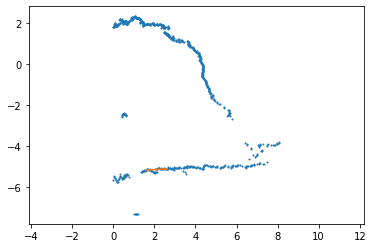

In [8]:
# Plot the point cloud (x, y only)
plt.axes().set_aspect('equal', 'datalim')
plt.plot(points[:, 0:1], points[:, 1:2], 'o', markersize= 1)
plt.plot([p1[0], p2[0]], [p1[1], p2[1]])

Function is_on_ground_plane(point, threshold) is the final answer to this problem

In [9]:
def is_on_ground_plane(point, threshold):
    p3= np.array([point[0], point[1]])
    d= abs((p2[0] - p1[0]) * (p1[1] - p3[1]) - (p1[0] - p3[0]) * (p2[1] - p1[1])) / np.sqrt(np.square(p2[0] - p1[0]) + np.square(p2[1] - p1[1]))
    if d < threshold:
        return True
    return False

Testing  is_on_ground_plane(point, threshold) 

In [10]:
p1_test= np.array([1.09361e-16, 1.786, 0, 0.01606775])
p2_test= np.array([2.074764, -5.267094, 0, 0.01663233])

print("p1 is on the ground plane: ", is_on_ground_plane(p1_test, 0.25))
print("p2 is on the ground plane: ", is_on_ground_plane(p2_test, 0.25))

p1 is on the ground plane:  False
p2 is on the ground plane:  True


Visualize the cloud point: which point is on the ground plane, which is not

Inliers:  181
Outliers:  539


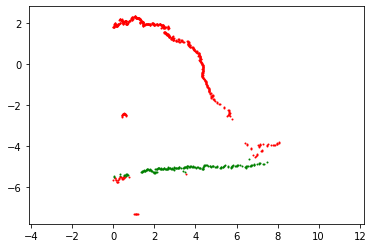

In [11]:
# Plot the point cloud (x, y only)
inlier_count= 0
plt.axes().set_aspect('equal', 'datalim')
for p in points:
    color= 'red'
    if is_on_ground_plane(p, threshold):
        color= 'green'
        inlier_count+= 1
    plt.plot(p[0], p[1], 'o', color=color, markersize= 1)
print("Inliers: ", inlier_count)
print("Outliers: ", len(points) - inlier_count)